# Baseline Classification Tasks
The purpose of these tasks is to determine how well linear classifiers can perform on our tasks as a baseline comparison.

In [57]:
#
# Imports for data loading and classification
#

import matplotlib.pyplot as plt
import numpy as np
import pandas as ps
from sklearn import grid_search
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA

#
# Setup matplotlib and ipython
#
%matplotlib inline

# random seed
R_SEED = 42

### Load input data

In [33]:

# These are our tasks:
all_tasks = ["helix","transmembrane-region","strand","nucleotide-phosphate-binding-region"]

# We assume there is a file in {data_path}/{task}.features.tsv with +1 labeled features,
# and another file in {data_path}/{task}.random_features.tsv with -1 labeled features.

def loadDataForTask(taskname, k) :
    """
    Loads the data for the given taskname.
    Returns: (X_matrix, Y_matrix) as numpy arrays
    """
    
    # Assume this is the path to the data
    data_path = '../../features_k' + str(k) + '/'
    
    # load an concatonate the feature matrixes
    # use the '.100k' varients which only contain 100k examples
    X1 = ps.read_table(data_path + taskname + '.features.tsv')
    XM1 = ps.read_table(data_path + taskname + '.random_features_bkgrd.tsv')
    frames = [X1, XM1]
    X = ps.concat(frames).as_matrix()
    
    # create label vectors
    Y = np.ones(X1.shape[0] + XM1.shape[0])
    Y[X1.shape[0]:] = -1
    
    return (X,Y)


### Try the method on transmembrane-region prediction

In [91]:
#
# Load test/dev data, and split 10% for testing
#
def getData(task, k) :
    #X,Y = loadDataForTask('transmembrane-region-small', 3)
    X,Y = loadDataForTask(task, k)
    X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.1, random_state=R_SEED)
    return X_dev, X_test, Y_dev, Y_test

In [92]:
#
# Make a PCA of the dev data
#
def makePCA(X_dev, Y_dev, task, k) :
    pca = PCA(n_components=2)
    X_dev_pca = pca.fit(X_dev).transform(X_dev)
    target_names = ['-', '+']

    print('explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))
    plt.figure(figsize=(8, 6))
    for c, i, target_name in zip("br", [-1,1], target_names):
        plt.scatter(X_dev_pca[Y_dev == i, 0], X_dev_pca[Y_dev == i, 1], c=c, label=target_name, alpha=0.25)
    plt.legend()
    plt.title('PCA of %s, k=%d' % (task, k))
    plt.show()


In [93]:
def makeRF(X_dev, X_test, Y_dev, Y_test) :

    clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=1, random_state=R_SEED)
    clf.fit(X_dev, Y_dev)
    y_pred = clf.predict(X_test)

    print 'confusion matrix:'
    print confusion_matrix(Y_test, y_pred)
    print '\ntest accuracy:'
    print accuracy_score(Y_test, y_pred)
    return clf

### Plot ROC

In [94]:
def plotROC(clf, X_test, Y_test, task, k) :

    test_probas = clf.predict_proba(X_test)[:,1]

    plt.figure(figsize=(8, 6), dpi=300)
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    # calculate ROC for test data
    fpr, tpr, thresholds = roc_curve(Y_test, test_probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='Test ROC (area = %0.2f)' % (roc_auc))

    # plot the CV and test ROCs
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for %s, k=%d' % (task, k))
    plt.legend(loc="lower right")
    plt.show()

### Perform parameter search

=== task: transmembrane-region-small == k= 1
explained variance ratio (first two components): [ 0.19342921  0.10723747]


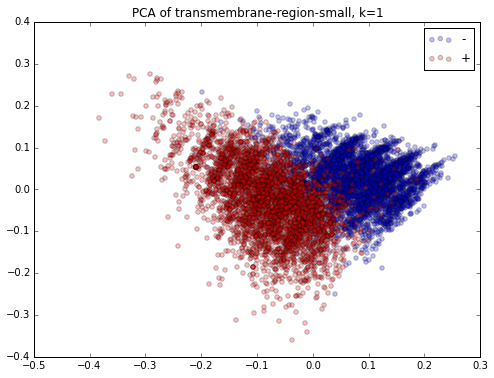

confusion matrix:
[[480  12]
 [ 12 496]]

test accuracy:
0.976


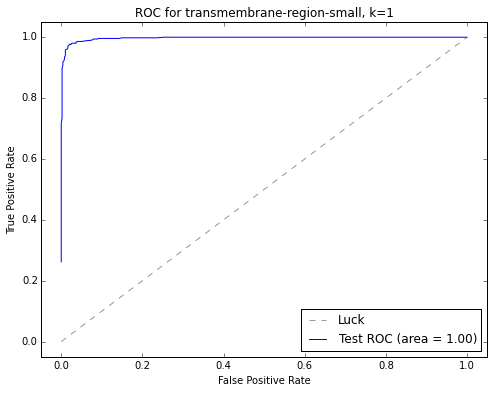

=== task: transmembrane-region-small == k= 2
explained variance ratio (first two components): [ 0.03882167  0.02221735]


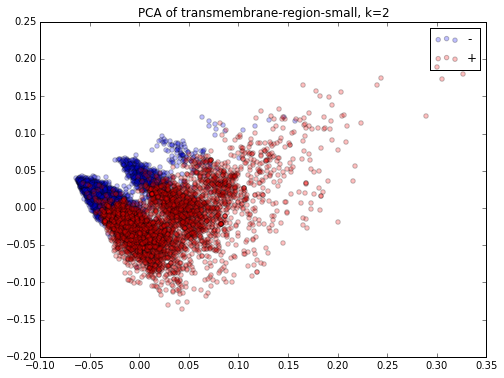

confusion matrix:
[[460  32]
 [ 17 491]]

test accuracy:
0.951


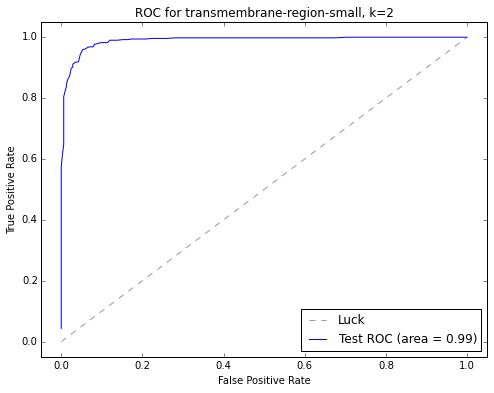

=== task: transmembrane-region-small == k= 3
explained variance ratio (first two components): [ 0.01403174  0.00945255]


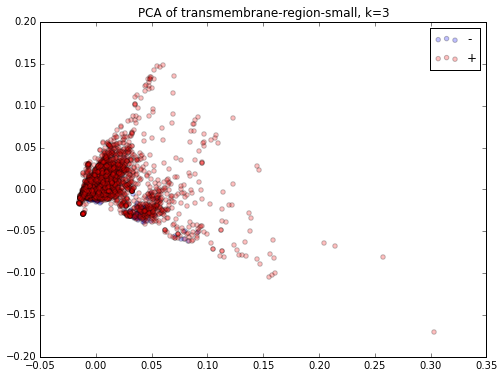

confusion matrix:
[[458  34]
 [159 349]]

test accuracy:
0.807


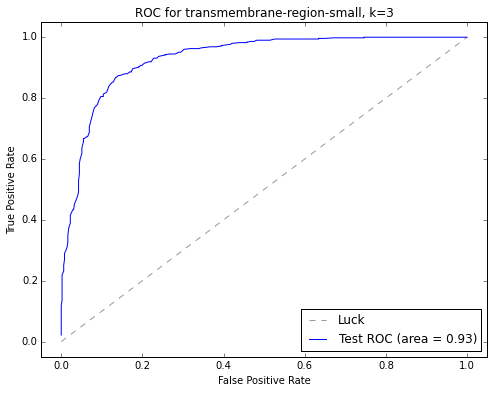

=== task: helix-small == k= 1
explained variance ratio (first two components): [ 0.09632094  0.0913769 ]


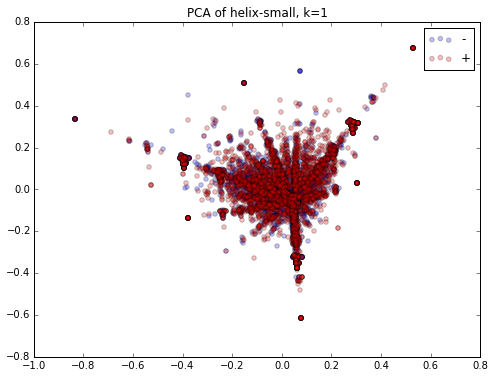

confusion matrix:
[[312 180]
 [175 333]]

test accuracy:
0.645


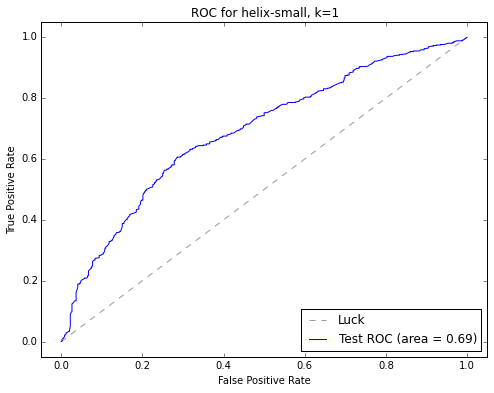

=== task: helix-small == k= 2
explained variance ratio (first two components): [ 0.09680416  0.09178394]


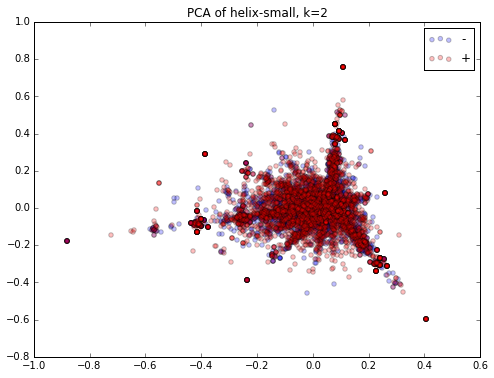

confusion matrix:
[[310 182]
 [183 325]]

test accuracy:
0.635


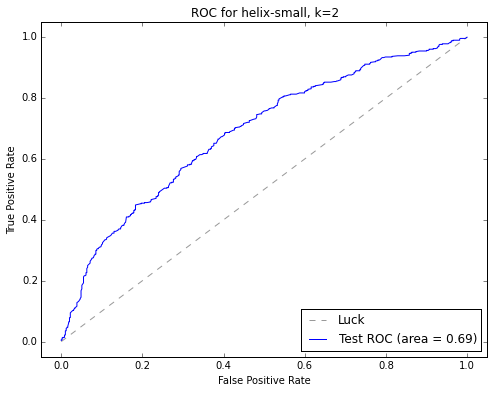

=== task: helix-small == k= 3
explained variance ratio (first two components): [ 0.00622427  0.00565239]


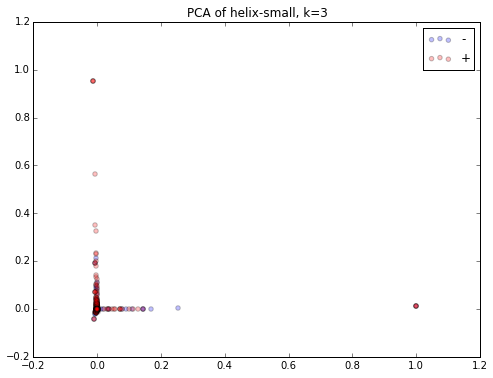

confusion matrix:
[[389 103]
 [295 213]]

test accuracy:
0.602


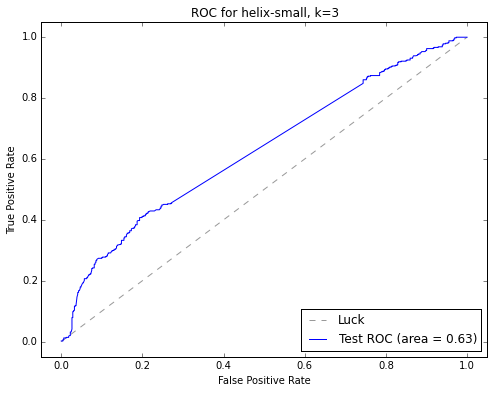

In [95]:
for task in['transmembrane-region-small', 'helix-small'] :
    for k in [1,2,3] :
        print '=== task: %s == k= %d' % (task, k)
        X_dev, X_test, Y_dev, Y_test = getData(task, k)
        makePCA(X_dev, Y_dev, task, k)
        clf = makeRF(X_dev, X_test, Y_dev, Y_test)
        plotROC(clf, X_test, Y_test, task, k)